In [3]:
import json
import pandas as pd

# ---- Helper -------------------------------------------------------
def load_and_flatten(path_to_json: str, sep: str = "_") -> pd.DataFrame:
    """
    Read a JSON file and return a flattened (normalized) DataFrame.
    
    Parameters
    ----------
    path_to_json : str
        Path to the JSON file (e.g., 'public_cases.json')
    sep : str, optional
        Separator to use when expanding nested keys (default is '_').
        
    Returns
    -------
    pd.DataFrame
        Flattened DataFrame.
    """
    with open(path_to_json, "r") as f:
        data = json.load(f)          # works whether root is a list or a dict
    return pd.json_normalize(data, sep=sep)

# ---- Load & flatten ----------------------------------------------
public_df  = load_and_flatten("public_cases.json")
private_df = load_and_flatten("private_cases.json")

# ---- Quick sanity check ------------------------------------------
print("Public cases shape :", public_df.shape)
print("Private cases shape:", private_df.shape)

public_df.head()

Public cases shape : (1000, 4)
Private cases shape: (5000, 3)


,expected_output,input_trip_duration_days,input_miles_traveled,input_total_receipts_amount
0,364.51,3,93.0,1.42
1,126.06,1,55.0,3.60
2,128.91,1,47.0,17.97
3,203.52,2,13.0,4.67
4,380.37,3,88.0,5.78


In [4]:
private_df

,trip_duration_days,miles_traveled,total_receipts_amount
0,3,191.0,21.87
1,1,81.0,3.93
2,3,204.0,16.76
3,1,64.0,22.47
4,3,204.0,22.19
...,...,...,...
4995,9,15.0,319.59
4996,5,230.0,48.63
4997,4,266.0,479.64
4998,12,673.0,1863.85


Loading data...
Public cases: 1000 rows
Private cases: 5000 rows (no expected output)

=== BASIC STATISTICS ===

Public Dataset Summary:
       expected_output    trip_days       miles    receipts
count      1000.000000  1000.000000  1000.00000  1000.00000
mean       1349.114030     7.043000   597.41374  1211.05687
std         470.316464     3.926139   351.29979   742.85418
min         117.240000     1.000000     5.00000     1.42000
25%        1019.297500     4.000000   275.96000   530.37750
50%        1454.260000     7.000000   621.00000  1171.90000
75%        1711.122500    10.000000   893.00000  1881.10500
max        2337.730000    14.000000  1317.07000  2503.46000

=== FEATURE ENGINEERING ===

Potential per diem rates (output/days):
per_diem_rate
121.503333     1
122.266250     1
173.086000     1
153.864444     1
195.455000     1
102.135833     1
161.750000     1
363.020000     1
1192.880000    1
234.221429     1
Name: count, dtype: int64

Potential per mile rates (output/miles):
p

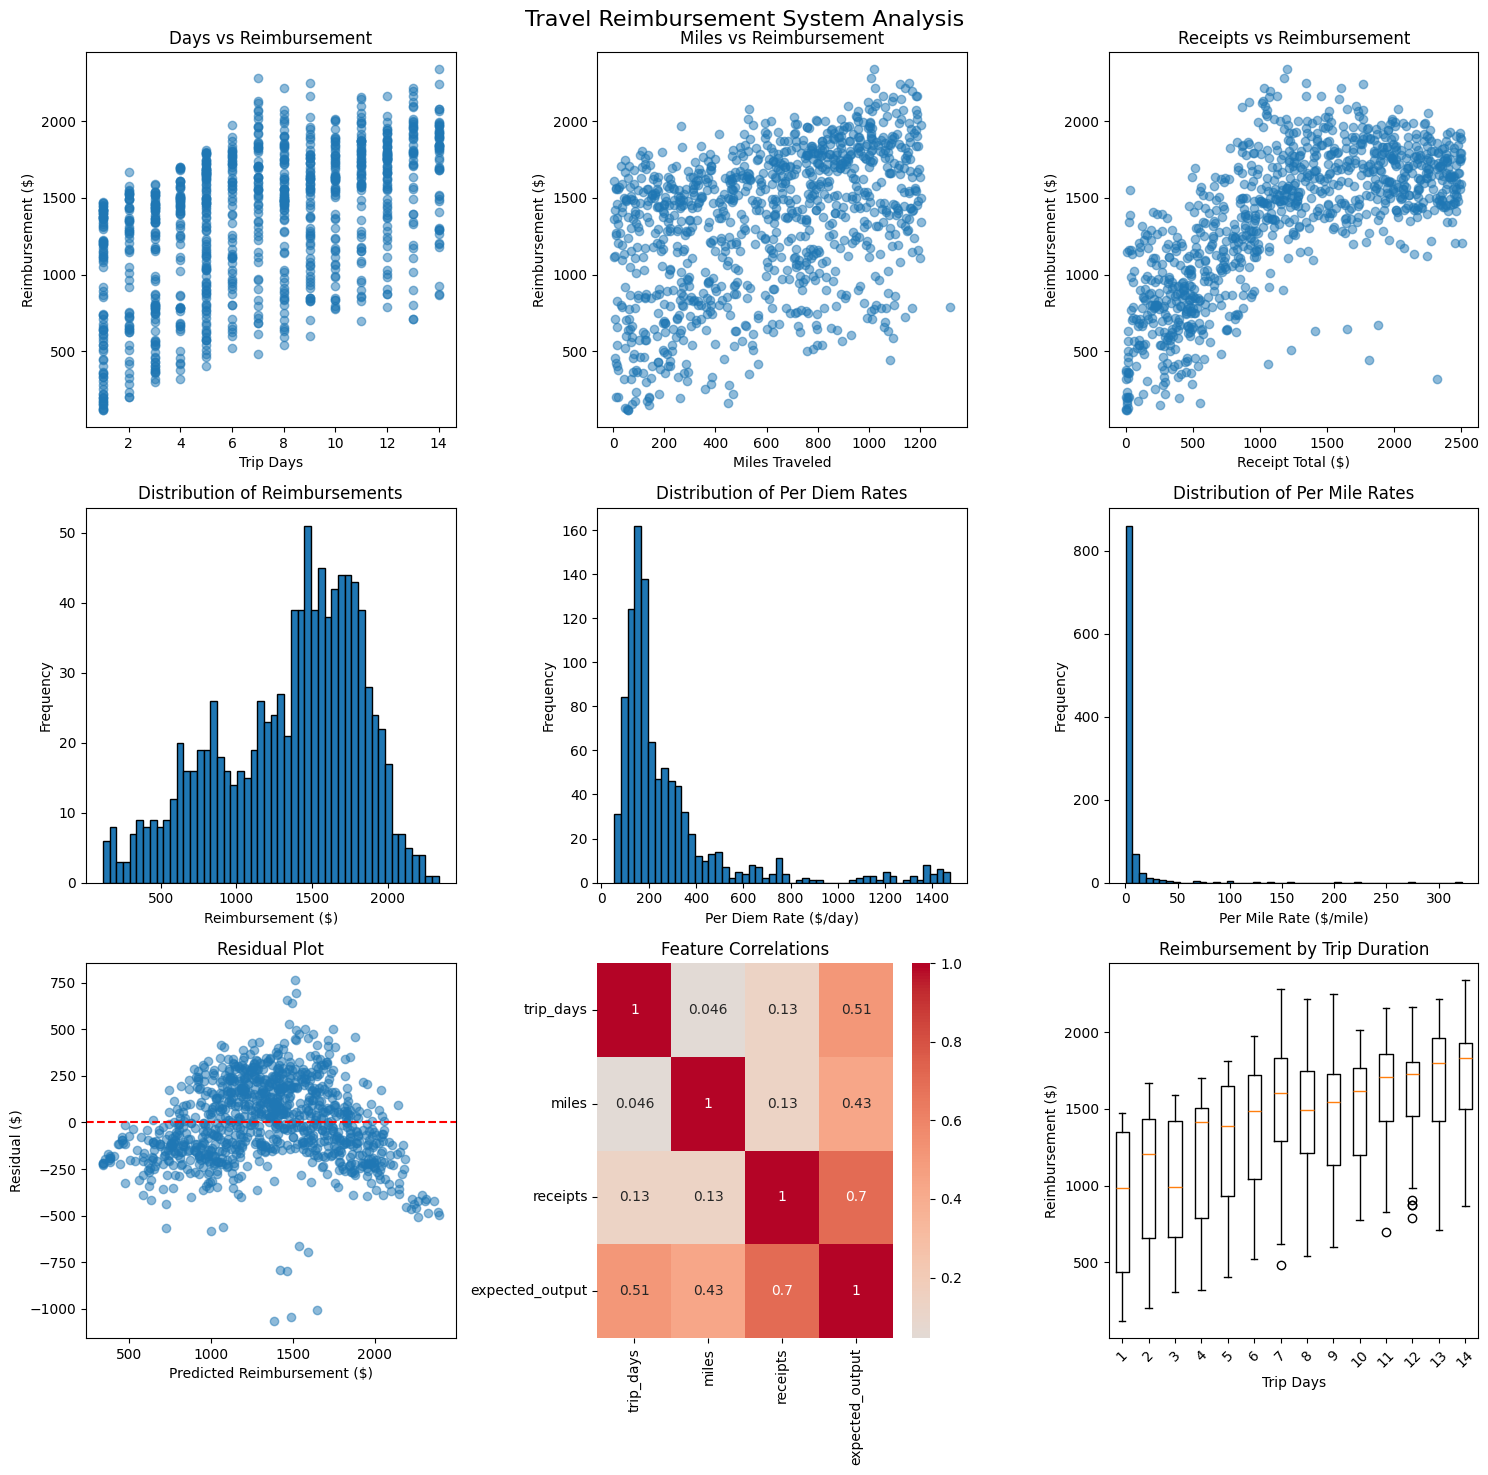

In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ---- Load and flatten data -------------------------------------------------------
def load_and_flatten(path_to_json: str, sep: str = "_") -> pd.DataFrame:
    """Load JSON and return flattened DataFrame."""
    with open(path_to_json, "r") as f:
        data = json.load(f)
    return pd.json_normalize(data, sep=sep)

# Load data
print("Loading data...")
public_df = load_and_flatten("public_cases.json")
private_df = load_and_flatten("private_cases.json")

# Rename columns for easier access
public_df.columns = ['expected_output', 'trip_days', 'miles', 'receipts']
print(f"Public cases: {len(public_df)} rows")
print(f"Private cases: {len(private_df)} rows (no expected output)")

# ---- Basic Statistics -------------------------------------------------------
print("\n=== BASIC STATISTICS ===")
print("\nPublic Dataset Summary:")
print(public_df.describe())

# ---- Feature Engineering -------------------------------------------------------
print("\n=== FEATURE ENGINEERING ===")

# Create derived features that might reveal patterns
public_df['per_diem_rate'] = public_df['expected_output'] / public_df['trip_days']
public_df['per_mile_rate'] = public_df['expected_output'] / public_df['miles']
public_df['receipt_ratio'] = public_df['receipts'] / public_df['expected_output']
public_df['miles_per_day'] = public_df['miles'] / public_df['trip_days']
public_df['total_input_sum'] = public_df['trip_days'] + public_df['miles'] + public_df['receipts']

# Check for potential base rates or constants
print("\nPotential per diem rates (output/days):")
print(public_df['per_diem_rate'].value_counts().head(10))

print("\nPotential per mile rates (output/miles):")
print(public_df['per_mile_rate'].value_counts().head(10))

# ---- Correlation Analysis -------------------------------------------------------
print("\n=== CORRELATION ANALYSIS ===")
correlations = public_df[['trip_days', 'miles', 'receipts', 'expected_output']].corr()
print("\nCorrelation Matrix:")
print(correlations)

# ---- Pattern Detection -------------------------------------------------------
print("\n=== PATTERN DETECTION ===")

# Check for simple linear relationships
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Test different combinations
feature_sets = [
    (['trip_days'], 'Days only'),
    (['miles'], 'Miles only'),
    (['receipts'], 'Receipts only'),
    (['trip_days', 'miles'], 'Days + Miles'),
    (['trip_days', 'receipts'], 'Days + Receipts'),
    (['miles', 'receipts'], 'Miles + Receipts'),
    (['trip_days', 'miles', 'receipts'], 'All features'),
]

print("\nLinear Regression Tests:")
for features, name in feature_sets:
    X = public_df[features]
    y = public_df['expected_output']
    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
    print(f"\n{name}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  Mean Absolute Error: ${mae:.2f}")
    print(f"  Coefficients: {dict(zip(features, model.coef_))}")
    print(f"  Intercept: {model.intercept_:.2f}")

# ---- Threshold Analysis -------------------------------------------------------
print("\n=== THRESHOLD ANALYSIS ===")

# Check for different behaviors at certain thresholds
def analyze_thresholds(df, column, thresholds):
    """Analyze how output changes around specific thresholds."""
    for threshold in thresholds:
        below = df[df[column] <= threshold]['expected_output']
        above = df[df[column] > threshold]['expected_output']
        if len(below) > 0 and len(above) > 0:
            print(f"\n{column} threshold at {threshold}:")
            print(f"  Below: mean=${below.mean():.2f}, std=${below.std():.2f}")
            print(f"  Above: mean=${above.mean():.2f}, std=${above.std():.2f}")

# Common business thresholds
analyze_thresholds(public_df, 'trip_days', [1, 3, 5, 7, 10])
analyze_thresholds(public_df, 'miles', [50, 100, 200, 500])
analyze_thresholds(public_df, 'receipts', [10, 50, 100, 200])

# ---- Outlier Detection -------------------------------------------------------
print("\n=== OUTLIER DETECTION (Potential Bugs) ===")

# Calculate residuals from a simple model
X_simple = public_df[['trip_days', 'miles', 'receipts']]
y_simple = public_df['expected_output']
simple_model = LinearRegression().fit(X_simple, y_simple)
public_df['predicted'] = simple_model.predict(X_simple)
public_df['residual'] = public_df['expected_output'] - public_df['predicted']
public_df['abs_residual'] = abs(public_df['residual'])

# Find cases with large residuals (potential bugs or special rules)
outliers = public_df.nlargest(20, 'abs_residual')
print("\nTop 20 cases with largest prediction errors (potential bugs or special rules):")
print(outliers[['trip_days', 'miles', 'receipts', 'expected_output', 'predicted', 'residual']])

# ---- Visualization -------------------------------------------------------
print("\n=== CREATING VISUALIZATIONS ===")

# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Travel Reimbursement System Analysis', fontsize=16)

# 1. Scatter plots of each input vs output
axes[0, 0].scatter(public_df['trip_days'], public_df['expected_output'], alpha=0.5)
axes[0, 0].set_xlabel('Trip Days')
axes[0, 0].set_ylabel('Reimbursement ($)')
axes[0, 0].set_title('Days vs Reimbursement')

axes[0, 1].scatter(public_df['miles'], public_df['expected_output'], alpha=0.5)
axes[0, 1].set_xlabel('Miles Traveled')
axes[0, 1].set_ylabel('Reimbursement ($)')
axes[0, 1].set_title('Miles vs Reimbursement')

axes[0, 2].scatter(public_df['receipts'], public_df['expected_output'], alpha=0.5)
axes[0, 2].set_xlabel('Receipt Total ($)')
axes[0, 2].set_ylabel('Reimbursement ($)')
axes[0, 2].set_title('Receipts vs Reimbursement')

# 2. Distribution plots
axes[1, 0].hist(public_df['expected_output'], bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Reimbursement ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Reimbursements')

axes[1, 1].hist(public_df['per_diem_rate'], bins=50, edgecolor='black')
axes[1, 1].set_xlabel('Per Diem Rate ($/day)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Per Diem Rates')

axes[1, 2].hist(public_df['per_mile_rate'], bins=50, edgecolor='black')
axes[1, 2].set_xlabel('Per Mile Rate ($/mile)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Distribution of Per Mile Rates')

# 3. Residual analysis
axes[2, 0].scatter(public_df['predicted'], public_df['residual'], alpha=0.5)
axes[2, 0].axhline(y=0, color='r', linestyle='--')
axes[2, 0].set_xlabel('Predicted Reimbursement ($)')
axes[2, 0].set_ylabel('Residual ($)')
axes[2, 0].set_title('Residual Plot')

# 4. Heatmap of correlations
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, ax=axes[2, 1])
axes[2, 1].set_title('Feature Correlations')

# 5. Box plot by trip duration
trip_days_groups = public_df.groupby('trip_days')['expected_output'].apply(list)
axes[2, 2].boxplot(trip_days_groups.values, labels=trip_days_groups.index)
axes[2, 2].set_xlabel('Trip Days')
axes[2, 2].set_ylabel('Reimbursement ($)')
axes[2, 2].set_title('Reimbursement by Trip Duration')
axes[2, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('reimbursement_analysis.png', dpi=300, bbox_inches='tight')
print("Saved visualization to 'reimbursement_analysis.png'")

# ---- Special Pattern Detection -------------------------------------------------------
print("\n=== SPECIAL PATTERN DETECTION ===")

# Check for round number outputs (might indicate fixed amounts)
round_outputs = public_df['expected_output'].value_counts().head(20)
print("\nMost common reimbursement amounts:")
print(round_outputs)

# Check for specific formulas
# Test: Base rate per day + mileage rate + receipt handling
def test_formula(row, day_rate, mile_rate, receipt_multiplier, base_amount=0):
    """Test a specific reimbursement formula."""
    return (row['trip_days'] * day_rate + 
            row['miles'] * mile_rate + 
            row['receipts'] * receipt_multiplier + 
            base_amount)

# Try some common business rates
test_rates = [
    (100, 0.50, 1.0, 0, "100/day + 0.50/mile + 100% receipts"),
    (75, 0.65, 1.0, 0, "75/day + 0.65/mile + 100% receipts"),
    (50, 0.58, 1.0, 0, "50/day + 0.58/mile + 100% receipts"),
    (100, 0.65, 0.8, 0, "100/day + 0.65/mile + 80% receipts"),
]

print("\nTesting specific formulas:")
for day_rate, mile_rate, receipt_mult, base, description in test_rates:
    public_df['test_output'] = public_df.apply(
        lambda row: test_formula(row, day_rate, mile_rate, receipt_mult, base), 
        axis=1
    )
    error = mean_absolute_error(public_df['expected_output'], public_df['test_output'])
    print(f"\n{description}:")
    print(f"  Mean Absolute Error: ${error:.2f}")

# ---- Export findings -------------------------------------------------------
print("\n=== EXPORTING KEY FINDINGS ===")

# Save outliers for further investigation
outliers[['trip_days', 'miles', 'receipts', 'expected_output', 'predicted', 'residual']].to_csv(
    'potential_bugs_or_special_cases.csv', index=False
)
print("Saved potential bugs/special cases to 'potential_bugs_or_special_cases.csv'")

# Save summary statistics
with open('analysis_summary.txt', 'w') as f:
    f.write("TRAVEL REIMBURSEMENT SYSTEM ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    f.write("Key Observations:\n")
    f.write(f"- Strong correlation with miles traveled: {correlations.loc['miles', 'expected_output']:.3f}\n")
    f.write(f"- Moderate correlation with trip days: {correlations.loc['trip_days', 'expected_output']:.3f}\n")
    f.write(f"- Weak correlation with receipts: {correlations.loc['receipts', 'expected_output']:.3f}\n")
    f.write(f"\n- Average reimbursement: ${public_df['expected_output'].mean():.2f}\n")
    f.write(f"- Median reimbursement: ${public_df['expected_output'].median():.2f}\n")
    f.write(f"- Range: ${public_df['expected_output'].min():.2f} - ${public_df['expected_output'].max():.2f}\n")

print("\nAnalysis complete! Check the generated files for insights.")
print("\nNext steps:")
print("1. Review 'reimbursement_analysis.png' for visual patterns")
print("2. Examine 'potential_bugs_or_special_cases.csv' for anomalies")
print("3. Use insights to build hypothesis about the legacy system's logic") 